In [2]:
import sys
import pickle
sys.path.append("/home/john/udacity/classes/05-Into_to_Machine_Learning/tools/")
sys.path.append("/home/john/udacity/classes/05-Into_to_Machine_Learning/final_project/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from __future__ import division

# Load data

In [3]:
import pickle
data_dict = pickle.load(open("final_project/final_project_dataset.pkl", "rb") )

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("notebook")
sns.set_style("darkgrid")

df = pd.DataFrame(data_dict).T
float_columns = [c for c in df.columns if c not in ['email_address', 'poi']]
df[float_columns] = df[float_columns].astype(float)
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


# Explore

## List and Categorize Features

In [5]:
financial_features = ['salary', 'deferral_payments', 'total_payments',
                      'loan_advances', 'bonus', 'restricted_stock_deferred',
                      'deferred_income', 'total_stock_value', 'expenses',
                      'exercised_stock_options', 'other', 'long_term_incentive',
                      'restricted_stock', 'director_fees']

email_features = ['to_messages', 'from_poi_to_this_person',
                  'from_messages', 'from_this_person_to_poi',
                  'shared_receipt_with_poi'] #ignore email address

## Class Distribution

In [6]:
print("{} of {} are POIs".format(len([p for p,f in data_dict.items() if f['poi']]), len(data_dict)))

18 of 146 are POIs


## Missing data

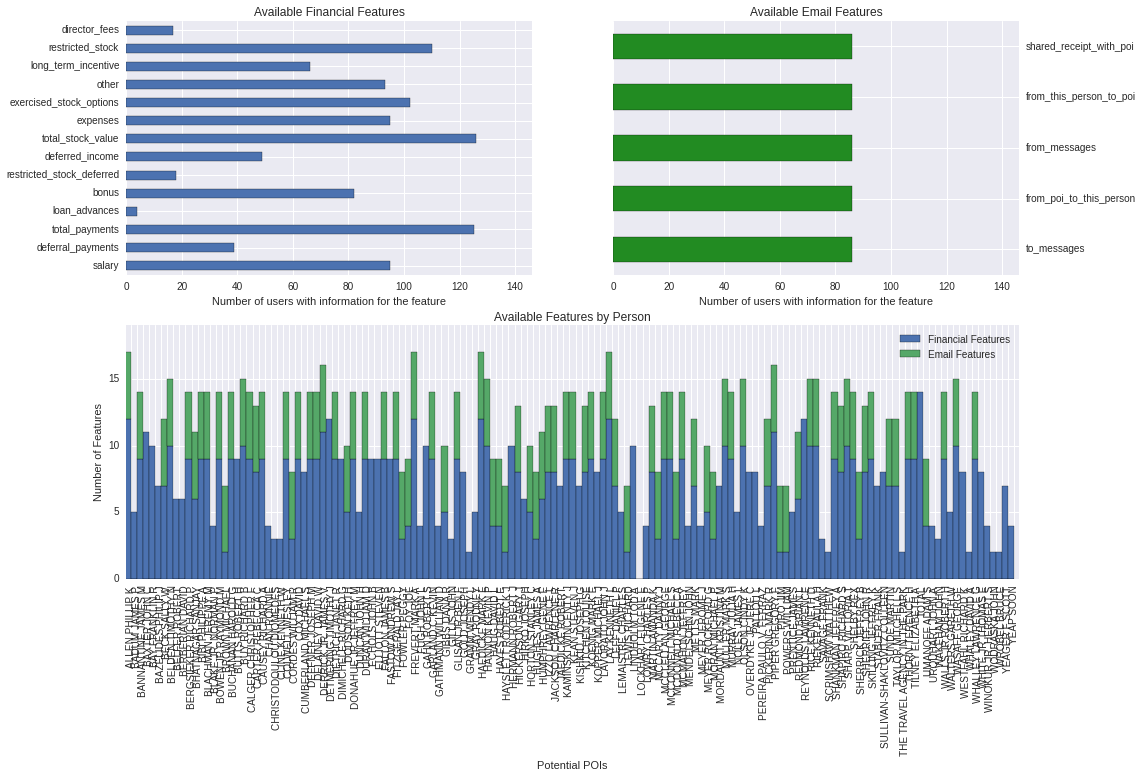

In [7]:
plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2), (1,0), colspan=2)

df[financial_features].count().plot(kind='barh', ax=ax1)
df[email_features].count().plot(kind='barh', ax=ax2, color='forestgreen')

person_df = pd.concat([df[financial_features].count(axis=1),
                    df[email_features].count(axis=1)],
                   keys=["Financial Features","Email Features"]).unstack().T
person_df.plot(kind='bar', ax=ax3, width=1, stacked=True)

ax2.yaxis.tick_right()
ax1.set_xlim(0,len(df))
ax2.set_xlim(0,len(df))
ax3.set_ylim(0,len(financial_features+email_features))

ax1.set_xlabel('Number of users with information for the feature')
ax2.set_xlabel('Number of users with information for the feature')
ax3.set_xlabel('Potential POIs')
ax3.set_ylabel('Number of Features')

ax1.set_title('Available Financial Features')
ax2.set_title('Available Email Features')
ax3.set_title('Available Features by Person')

plt.savefig('Fig1_MissingData.png', bbox_inches='tight')

## Outliers 

In [7]:
#Perform a simple check to see which rows have outliers, assuming normal distribution
zscores = df.apply(lambda row: (row-df.mean())/df.std(), axis=1)
for idx, row in zscores.iterrows():
    if max(row) >= 4:
        col = row.idxmax()
        val = row[row.idxmax()]
        print("{} has high '{}' value of {} (z-score of {})".format(idx, col, df[col][idx], val))
    if min(row) <= -4:
        col = row.idxmin()
        val = row[row.idxmin()]
        print("{} has low '{}' value of {} (z-score of {})".format(idx, col, df[col][idx], val))

DELAINEY DAVID W has high 'from_this_person_to_poi' value of 609.0 (z-score of 5.67352642171)
KAMINSKI WINCENTY J has high 'from_messages' value of 14368.0 (z-score of 7.47363149225)
KEAN STEVEN J has high 'to_messages' value of 12754.0 (z-score of 4.13525979734)
LAVORATO JOHN J has high 'from_poi_to_this_person' value of 528.0 (z-score of 5.32431220222)
SHAPIRO RICHARD S has high 'to_messages' value of 15149.0 (z-score of 5.06258356331)
TOTAL has high 'total_stock_value' value of 434509511.0 (z-score of 10.9794663182)
TOTAL has low 'deferred_income' value of -27992891.0 (z-score of -6.67073416501)


In [8]:
#Drop and Re-check
df = df.drop('TOTAL')
df = df.drop('THE TRAVEL AGENCY IN THE PARK')

#Perform a simple check to see which rows have outliers, assuming normal distribution
zscores = df.apply(lambda row: (row-df.mean())/df.std(), axis=1)
for idx, row in zscores.iterrows():
    if max(row) >= 4:
        col = row.idxmax()
        val = row[row.idxmax()]
        print("{} has high '{}' value of {} (z-score of {})".format(idx, col, df[col][idx], val))
    if min(row) <= -4:
        col = row.idxmin()
        val = row[row.idxmin()]
        print("{} has low '{}' value of {} (z-score of {})".format(idx, col, df[col][idx], val))

DELAINEY DAVID W has high 'from_this_person_to_poi' value of 609.0 (z-score of 5.67352642171)
FREVERT MARK A has high 'other' value of 7427621.0 (z-score of 4.98163159998)
KAMINSKI WINCENTY J has high 'from_messages' value of 14368.0 (z-score of 7.47363149225)
KEAN STEVEN J has high 'to_messages' value of 12754.0 (z-score of 4.13525979734)
LAVORATO JOHN J has high 'from_poi_to_this_person' value of 528.0 (z-score of 5.32431220222)
LAY KENNETH L has high 'total_payments' value of 103559793.0 (z-score of 10.5954047506)
SHAPIRO RICHARD S has high 'to_messages' value of 15149.0 (z-score of 5.06258356331)
SKILLING JEFFREY K has high 'salary' value of 1111258.0 (z-score of 4.66982018198)
WHITE JR THOMAS E has high 'restricted_stock' value of 13847074.0 (z-score of 5.64486498335)


In [9]:
#Remove "THE TRAVEL AGENCY IN THE PARK" since it isn't a person
data_dict.pop('THE TRAVEL AGENCY IN THE PARK')
#Remove "Total" row
data_dict.pop('TOTAL')

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

# Initial Classifier Test

In [10]:
from sklearn.cross_validation import StratifiedShuffleSplit, cross_val_score

def fit_and_test(classifiers, features, labels):
    """Fit, test, and plot a dict of classifiers"""
    sss_test = StratifiedShuffleSplit(labels, 1000, test_size=0.3, random_state=42)
    fig, axes = plt.subplots(1, len(classifiers), figsize=(15,5))
    
    for idx, clfname in enumerate(sorted(classifiers.keys())):
        clf = classifiers[clfname]
        precision = cross_val_score(clf, features, labels, 'precision', sss_test)
        recall = cross_val_score(clf, features, labels, 'recall', sss_test)
        mean = lambda a: sum(a)/len(a)
        sns.kdeplot(precision, recall, ax=axes[idx])
        axes[idx].set_title(clfname)
        axes[idx].set_xlabel('Precision\nMean = {:.4}\nMedian = {:.4}'.format(mean(precision),
                                                                               np.median(precision)))
        axes[idx].set_ylabel('Recall\nMean = {:.4}\nMedian = {:.4}'.format(mean(recall),
                                                           np.median(recall)))
        axes[idx].set_xlim(0,1)
        axes[idx].set_ylim(0,1)
    plt.tight_layout()   

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Imputer

In [12]:
features_list = ['poi'] + financial_features + email_features
my_dataset = data_dict
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

/home/john/miniconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/john/miniconda3/envs/python2/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/john/miniconda3/envs/python2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


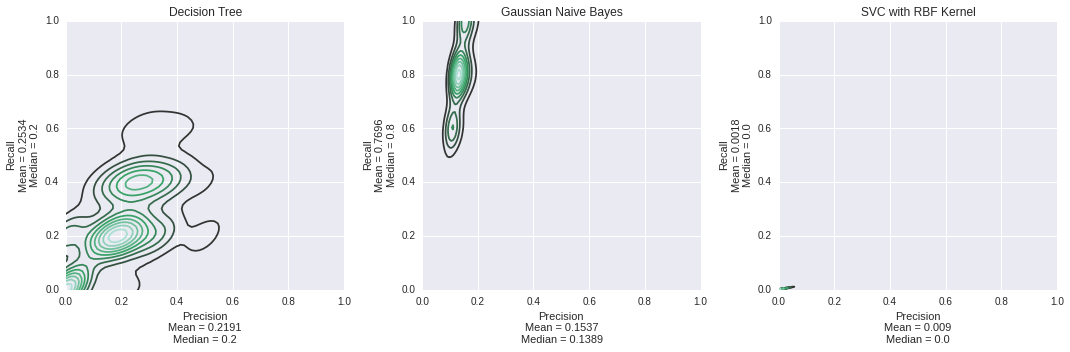

In [13]:
classifiers = {}
classifiers['Decision Tree'] = make_pipeline(Imputer(), DecisionTreeClassifier())
classifiers['SVC with RBF Kernel'] = make_pipeline(Imputer(), StandardScaler(), SVC(kernel='rbf'))
classifiers['Gaussian Naive Bayes'] = make_pipeline(Imputer(), StandardScaler(), GaussianNB())

fit_and_test(classifiers, features, labels)

plt.savefig(filename='Fig2_InitialClassification.png', bbox_inches='tight')

# Optimized Parameters

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.grid_search import GridSearchCV

def fit_and_get_best_params(gridsearches, features, labels):
    """Fit and return best classifier for each gridsearch in a dict"""
    best = {}
    for idx, clfname in enumerate(sorted(gridsearches.keys())):
        clf = gridsearches[clfname]
        clf.fit(features, labels)
        best[clfname] = clf.best_estimator_
    return best     

In [15]:
gridsearches = {}
sss_fit = StratifiedShuffleSplit(labels, 30, test_size=0.3, random_state=42)

#Decision Tree
parameters = {'decisiontreeclassifier__min_samples_split':range(2,12),
              'decisiontreeclassifier__min_samples_leaf':range(1,8)}
pipe = make_pipeline(Imputer(), DecisionTreeClassifier())
gridsearches['Decision Tree'] = GridSearchCV(pipe, parameters, cv=sss_fit, scoring='f1_weighted')

#SVC
pipe = make_pipeline(Imputer(), StandardScaler(), SelectKBest(), SVC(kernel='rbf'))
parameters = {'selectkbest__k':range(3,14),
              'svc__C':[10**n for n in range(-3,3)],
              'svc__gamma':[10**n for n in range(-4,3)],
              'svc__class_weight':[{1:n} for n in [1,2,4,8,16,32]]
             }
gridsearches['SVC with RBF Kernel'] = GridSearchCV(pipe, parameters, cv=sss_fit, scoring='f1_weighted')

#Gaussian Naive Bayes
pipe = make_pipeline(Imputer(), StandardScaler(), SelectKBest(), GaussianNB())
parameters = {'selectkbest__k':range(3,14)}
gridsearches['Gaussian Naive Bayes'] = GridSearchCV(pipe, parameters, cv=sss_fit, scoring='f1_weighted')

fittedclfs = fit_and_get_best_params(gridsearches, features, labels)

/home/john/miniconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/home/john/miniconda3/envs/python2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [3] are constant.
  UserWarning)


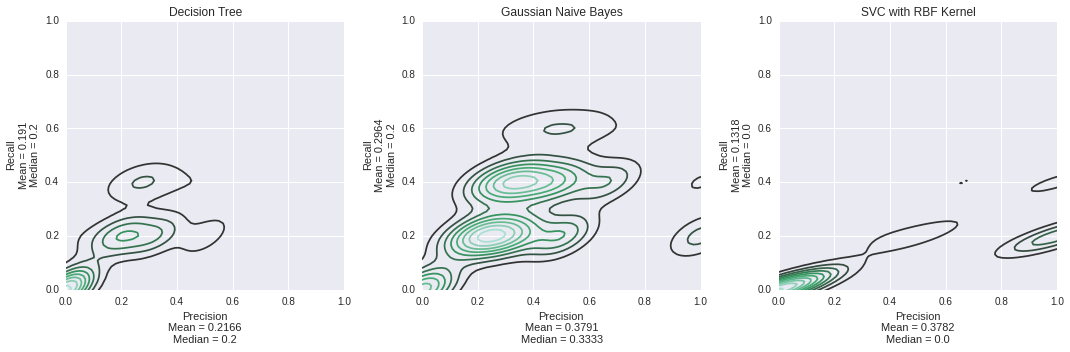

In [16]:
fit_and_test(fittedclfs, features, labels)
plt.savefig('Fig3_GridSearch.png', bbox_inches='tight')

# New Features

In [17]:
def fillzero(value):
    if value == 'NaN':
        return 0
    else:
        return value

for k,v in data_dict.items():
    v['from_poi_norm'] = float(v['from_poi_to_this_person'])/float(v['from_messages'])
    v['to_poi_norm'] = float(v['from_this_person_to_poi'])/float(v['to_messages'])
    v['shared_poi_norm'] = float(v['shared_receipt_with_poi'])/float(v['to_messages'])
    v['email_info_available'] = 1 if v['to_messages']!='NaN' else 0
    for ff in financial_features:
        v[ff+"_fill0"] = fillzero(v[ff])
        
features_list = ['poi'] + [ff+'_fill0' for ff in financial_features] +\
                ['from_poi_norm', 'to_poi_norm', 'shared_poi_norm', 'email_info_available']
my_dataset = data_dict
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [18]:
gridsearches = {}
sss_fit = StratifiedShuffleSplit(labels, 30, test_size=0.3, random_state=42)

#Decision Tree
parameters = {'decisiontreeclassifier__min_samples_split':range(2,12),
              'decisiontreeclassifier__min_samples_leaf':range(1,8)}
pipe = make_pipeline(Imputer(), DecisionTreeClassifier())
gridsearches['Decision Tree'] = GridSearchCV(pipe, parameters, cv=sss_fit, scoring='f1_weighted')

#SVC
pipe = make_pipeline(Imputer(), StandardScaler(), SelectKBest(), SVC(kernel='rbf'))
parameters = {'selectkbest__k':range(3,14),
              'svc__C':[10**n for n in range(-3,3)],
              'svc__gamma':[10**n for n in range(-4,3)],
              'svc__class_weight':[{1:n} for n in [1,2,4,8,16,32]]
             }
gridsearches['SVC with RBF Kernel'] = GridSearchCV(pipe, parameters, cv=sss_fit, scoring='f1_weighted')

#Gaussian Naive Bayes
pipe = make_pipeline(Imputer(), StandardScaler(), SelectKBest(), GaussianNB())
parameters = {'selectkbest__k':range(3,14)}
gridsearches['Gaussian Naive Bayes'] = GridSearchCV(pipe, parameters, cv=sss_fit, scoring='f1_weighted')

fittedclfs_new = fit_and_get_best_params(gridsearches, features, labels)

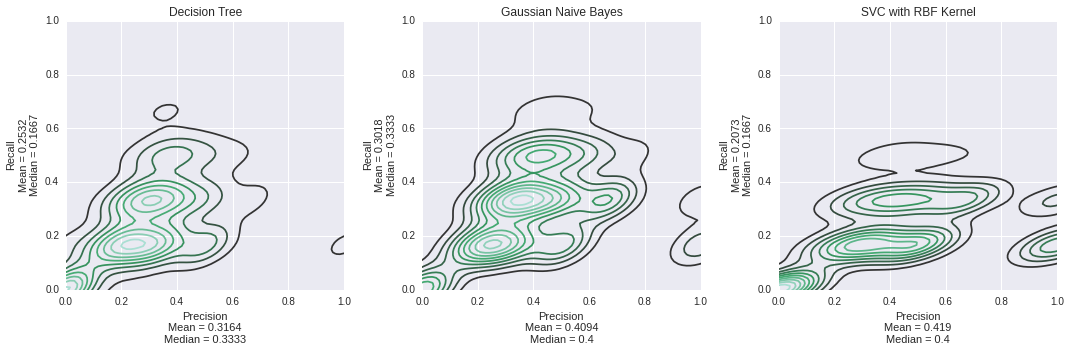

In [19]:
fit_and_test(fittedclfs_new, features, labels)
plt.savefig('Fig4_GridSearch_NewFeatures.png', bbox_inches='tight')

## Details of final classifiers

In [20]:
for clfname, clf in fittedclfs_new.items():
    print(clfname+":")
    for k,v in clf.get_params().items():
        print(k, v)
    print('-'*20)

SVC with RBF Kernel:
('selectkbest', SelectKBest(k=5, score_func=<function f_classif at 0x7fca139b9cf8>))
('svc__random_state', None)
('svc__gamma', 0.01)
('svc__max_iter', -1)
('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0))
('svc__C', 1)
('standardscaler__copy', True)
('imputer__verbose', 0)
('svc__kernel', 'rbf')
('svc__verbose', False)
('svc__cache_size', 200)
('svc__shrinking', True)
('svc__probability', False)
('standardscaler__with_mean', True)
('selectkbest__score_func', <function f_classif at 0x7fca139b9cf8>)
('standardscaler__with_std', True)
('selectkbest__k', 5)
('svc__tol', 0.001)
('imputer__axis', 0)
('svc__class_weight', {1: 4})
('svc__degree', 3)
('imputer__missing_values', 'NaN')
('svc', SVC(C=1, cache_size=200, class_weight={1: 4}, coef0=0.0, degree=3, gamma=0.01,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))
('standardscaler', StandardScaler(copy=True, with_mean

In [21]:
#Decision Tree Features
selected_features = fittedclfs_new['Decision Tree'].get_params()['decisiontreeclassifier'].feature_importances_
print('Decision Tree:')
for idx, sf in enumerate(sorted(selected_features, reverse=True)):
    print("{} = {:.4}".format(features_list[idx+1], sf))
print('\n')

#SVC Features
selected_features = fittedclfs_new['SVC with RBF Kernel'].get_params()['selectkbest'].get_support(indices=True)
print('SVC with RBF Kernel:')
print([features_list[i+1] for i in selected_features]) #add 1 to ignore 'poi'
print('\n')

#Gaussian Naive Bayes Features
selected_features = fittedclfs_new['Gaussian Naive Bayes'].get_params()['selectkbest'].get_support(indices=True)
print('Gaussian Naive Bayes')
print([features_list[i+1] for i in selected_features]) #add 1 to ignore 'poi'
print('\n')

Decision Tree:
salary_fill0 = 0.3886
deferral_payments_fill0 = 0.1713
total_payments_fill0 = 0.1284
loan_advances_fill0 = 0.1104
bonus_fill0 = 0.05674
restricted_stock_deferred_fill0 = 0.05674
deferred_income_fill0 = 0.04817
total_stock_value_fill0 = 0.03972
expenses_fill0 = 0.0
exercised_stock_options_fill0 = 0.0
other_fill0 = 0.0
long_term_incentive_fill0 = 0.0
restricted_stock_fill0 = 0.0
director_fees_fill0 = 0.0
from_poi_norm = 0.0
to_poi_norm = 0.0
shared_poi_norm = 0.0
email_info_available = 0.0


SVC with RBF Kernel:
['salary_fill0', 'bonus_fill0', 'deferred_income_fill0', 'total_stock_value_fill0', 'exercised_stock_options_fill0']


Gaussian Naive Bayes
['salary_fill0', 'bonus_fill0', 'deferred_income_fill0', 'total_stock_value_fill0', 'exercised_stock_options_fill0', 'long_term_incentive_fill0', 'restricted_stock_fill0']


